In [2]:
!pip install torch
!pip install pytorch-lightning
!pip install matplotlib
!pip install tensorboard
!pip install torch torchvision
!pip install pillow
!pip install torchsummary

Looking in indexes: https://pypi.org/simple/
Looking in indexes: https://pypi.org/simple/
Looking in indexes: https://pypi.org/simple/
Looking in indexes: https://pypi.org/simple/


Looking in indexes: https://pypi.org/simple/
Looking in indexes: https://pypi.org/simple/
Looking in indexes: https://pypi.org/simple/


In [3]:
# Import necessary libraries and modules
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import Dataset, DataLoader
from torchmetrics.functional import accuracy as ACC
from torchsummary import summary
from torchvision import transforms
from torchvision.transforms import Compose, Resize, ToTensor
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as T


In [4]:
def check_gpu():
    if torch.cuda.is_available():
        print("GPU is available.")
        print("GPU Device Name:", torch.cuda.get_device_name(0))  # Get the name of the first GPU device
        print("GPU Device Count:", torch.cuda.device_count())  # Get the number of available GPUs
        print("CUDA Version:", torch.version.cuda)  # Get the installed CUDA version
        print("PyTorch Version:", torch.__version__)  # Get the installed PyTorch version
    else:
        print("GPU is not available. Using CPU.")

if __name__ == "__main__":
    check_gpu()

GPU is not available. Using CPU.


In [5]:
def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Set the seed for reproducibility
set_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)
print(torch.cuda.is_available())

Device: cpu
False


In [6]:
class Load_Preprocess():
    def __init__(self):
        self.train_client_file = 'C:/Users/Dell/Desktop/NormalizedFace/client_train_normalized.txt'
        self.train_imposter_file = 'C:/Users/Dell/Desktop/NormalizedFace/imposter_train_normalized.txt'

        self.test_client_file = 'C:/Users/Dell/Desktop/NormalizedFace/client_test_normalized.txt'
        self.test_imposter_file = 'C:/Users/Dell/Desktop/NormalizedFace/imposter_test_normalized.txt'
    def preprocessing(self):

        # Train
        Train = ['C:/Users/Dell/Desktop/NormalizedFace/ClientNormalized/'+line.rstrip('\n') for line in open(self.train_client_file, 'r').readlines()]
        Train_labels = [0]*len(Train)
        
        temp = ['C:/Users/Dell/Desktop/NormalizedFace/ImposterNormalized/'+line.rstrip('\n') for line in open(self.train_imposter_file, 'r').readlines()]
        Train += temp
        Train_labels += [1]*len(temp)
        
# Test
        Test = ['C:/Users/Dell/Desktop/NormalizedFace/ClientNormalized/'+line.rstrip('\n') for line in open(self.test_client_file, 'r').readlines()]
        Test_labels = [0]*len(Test)
        
        temp = ['C:/Users/Dell/Desktop/NormalizedFace/ImposterNormalized/'+line.rstrip('\n') for line in open(self.test_imposter_file, 'r').readlines()]
        Test += temp
        Test_labels += [1]*len(temp)
        
        Test, Valid, Test_labels, Val_labels = train_test_split(Test, Test_labels, test_size=0.5, random_state=42)
 
        return Train, Train_labels, Valid, Val_labels, Test, Test_labels

Train, Train_labels, Valid, Val_labels, Test, Test_labels = Load_Preprocess().preprocessing()

In [15]:
# Print the first few image paths
print("Size of Train set:", len(Train), len(Train_labels))
print("Size of Validation set:", len(Valid), len(Val_labels))
print("Size of Test set:", len(Test), len(Test_labels))

Size of Train set: 3491 3491
Size of Validation set: 4562 4562
Size of Test set: 4561 4561


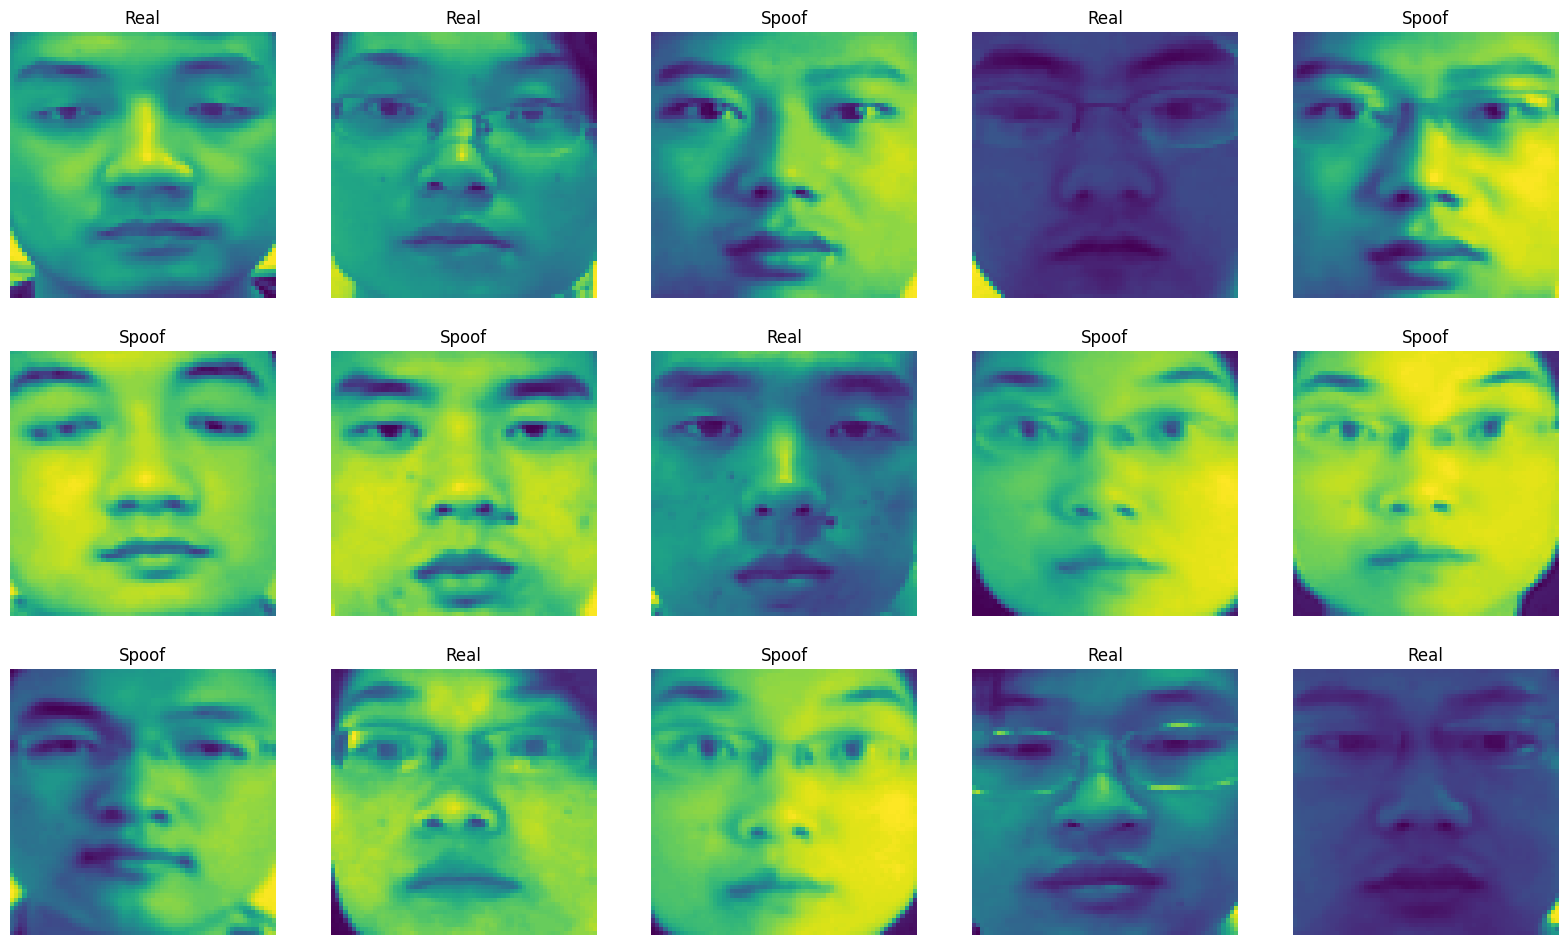

In [59]:
# Random selection of 15 images 
face_dic = {0: 'Real', 1: 'Spoof'}
plt.figure(figsize=(20, 20))
files = 15
for i in range(files):
    plt.subplot(5, 5, i+1)
    k = random.randint(0, len(Train))
    img = Image.open(Train[k])

    plt.imshow(img)
    plt.title(face_dic[Train_labels[k]])
    plt.axis('off')

In [8]:
# Data generators for augmentation and normalization
transform = T.Compose([transforms.ToPILImage(),
                      transforms.Resize((64,64)),#224
                      transforms.RandomRotation(20),  
                      transforms.ToTensor(),
                              ])

class FaceSpoofDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.images = paths
        self.Labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.Labels)
    def __getitem__(self, idx):
        image = cv2.imread(self.images[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = torch.tensor(int(self.Labels[idx]), dtype=torch.int64)
        
        if self.transform:
            image = self.transform(image)
        return image, label

train_dataset = FaceSpoofDataset(Train, Train_labels, transform = transform)
Val_dataset = FaceSpoofDataset(Valid, Val_labels, transform = transform)
test_dataset = FaceSpoofDataset(Test, Test_labels, transform = transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(Val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [9]:
# Model Class
class BinaryImageClassifier(nn.Module):
    def __init__(self):
        super(BinaryImageClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 512, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)

        self.pool = nn.AvgPool2d(3, 3)
    
        self.dropout = nn.Dropout(p=0.2)

        self.fc1 = nn.Linear(2*128*2, 256)
        self.fc2 = nn.Linear(256, 1024)
        self.out = nn.Linear(1024, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        out = self.out(x)
        return out

net = BinaryImageClassifier().to(device)

summary(net, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 512, 64, 64]          14,336
         AvgPool2d-2          [-1, 512, 21, 21]               0
            Conv2d-3          [-1, 256, 21, 21]       1,179,904
         AvgPool2d-4            [-1, 256, 7, 7]               0
            Conv2d-5            [-1, 128, 7, 7]         295,040
         AvgPool2d-6            [-1, 128, 2, 2]               0
            Linear-7                  [-1, 256]         131,328
            Linear-8                 [-1, 1024]         263,168
            Linear-9                    [-1, 2]           2,050
Total params: 1,885,826
Trainable params: 1,885,826
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 18.74
Params size (MB): 7.19
Estimated Total Size (MB): 25.98
-------------------------------------

In [10]:
# PyTorch Lightning
class FaceSpoofModel(pl.LightningModule): #------> # is a custom model
    def __init__(self):
        super(FaceSpoofModel, self).__init__()
        self.model = BinaryImageClassifier() #------> Responsible for processing the input images and making predictions.
        self.CE = nn.CrossEntropyLoss() #---->  is the loss function used for training the model.

    def forward(self, x): #-----> This method defines the forward pass of the model.
        return self.model(x) 

    def training_step(self, batch, batch_idx): # --> Calculates the loss, logs, and returns the loss.
        images, labels = batch
        preds = self(images)
        
        loss = self.CE(preds, labels)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx): #--> calculates the loss.
        images, labels = batch
        preds = self(images)
        loss = self.CE(preds, labels)
        self.log('val_loss', loss, prog_bar=True)
    
    def test_step(self, test_batch, batch_idx):
        images, labels = test_batch
        preds = self.forward(images)
        loss = self.CE(preds, labels)
        acc = ACC(preds, labels, task="multiclass", num_classes=2)
        
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)

        print('Test_acc', acc)

    def predict_step(self, test_batch, batch_idx):
        images, labels = test_batch
        return self.forward(images)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer


In [14]:
# The model will be moved to the GPU with index 0 if available, otherwise to the CPU.
model = FaceSpoofModel().to(device)

In [15]:
# Training the model
trainer = pl.Trainer(max_epochs=32)
trainer.fit(model, train_loader, valid_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type                  | Params
------------------------------------------------
0 | model | BinaryImageClassifier | 1.9 M 
1 | CE    | CrossEntropyLoss      | 0     
------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.543     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\loops\fit_loop.py:280: PossibleUserWarning: The number of training bat

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=32` reached.


In [16]:
# Test dataset using a trainer or testing framework
trainer.test(model, test_loader)

C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

Test_acc tensor(0.6016)
Test_acc tensor(0.6406)
Test_acc tensor(0.6016)
Test_acc tensor(0.6953)
Test_acc tensor(0.6406)
Test_acc tensor(0.5469)
Test_acc tensor(0.6719)
Test_acc tensor(0.5859)
Test_acc tensor(0.6484)
Test_acc tensor(0.6016)
Test_acc tensor(0.6094)
Test_acc tensor(0.6094)
Test_acc tensor(0.6484)
Test_acc tensor(0.5391)
Test_acc tensor(0.6484)
Test_acc tensor(0.6328)
Test_acc tensor(0.7344)
Test_acc tensor(0.5703)
Test_acc tensor(0.6094)
Test_acc tensor(0.5391)
Test_acc tensor(0.6562)
Test_acc tensor(0.5703)
Test_acc tensor(0.6250)
Test_acc tensor(0.5391)
Test_acc tensor(0.5391)
Test_acc tensor(0.6328)
Test_acc tensor(0.6406)
Test_acc tensor(0.6094)
Test_acc tensor(0.5156)
Test_acc tensor(0.6094)
Test_acc tensor(0.7422)
Test_acc tensor(0.6094)
Test_acc tensor(0.5938)
Test_acc tensor(0.6406)
Test_acc tensor(0.6094)
Test_acc tensor(0.5926)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6141197085380554     │
│         test_loss         │    13.225473403930664     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 13.225473403930664, 'test_acc': 0.6141197085380554}]

In [17]:
# Prediction framework
predictions = trainer.predict(model, test_loader)

C:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [18]:
# Shape of the first element in predictions
predictions[0].shape

torch.Size([128, 2])

In [19]:
# Model Evaluation and Analysis
def evaluate_model(model, test_loader, device):
    model.eval()  #------> Set the model to evaluation mode
    y_true = []   #------> Ground truth labels
    y_pred = []   #------> Predicted labels (logits)

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            y_pred.extend(logits.cpu().numpy())   #------> Append logits to the predicted labels list
            y_true.extend(labels.cpu().numpy())   #------> Append ground truth labels to the true labels list

    y_pred_probs = F.softmax(torch.tensor(y_pred), dim=1).cpu().numpy()  #------> Convert logits to probabilities
    y_pred_labels = torch.argmax(torch.tensor(y_pred), dim=1).cpu().numpy()  #------> Convert logits to class labels

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred_labels)
    precision = precision_score(y_true, y_pred_labels)
    recall = recall_score(y_true, y_pred_labels)
    f1 = f1_score(y_true, y_pred_labels)
    roc_auc = roc_auc_score(y_true, y_pred_probs[:, 1])  #------> Assuming binary classification (Real or Spoof)

    # Print evaluation metrics
    print("Model Evaluation:")
    print("Accuracy: {:.4f}".format(accuracy))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1-Score: {:.4f}".format(f1))
    print("ROC-AUC: {:.4f}".format(roc_auc))

    return accuracy, precision, recall, f1, roc_auc

# Evaluate the model using the evaluate_model function
model = model.to(device)  
accuracy, precision, recall, f1, roc_auc = evaluate_model(model, test_loader, device)


Model Evaluation:
Accuracy: 0.6128
Precision: 0.6460
Recall: 0.8732
F1-Score: 0.7426
ROC-AUC: 0.2351


C:\Program Files\KMSpico\temp\ipykernel_6132\1414030020.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  y_pred_probs = F.softmax(torch.tensor(y_pred), dim=1).cpu().numpy()  # Convert logits to probabilities


In [20]:
# Evaluation Metrics
def evaluate_model(model, dataloader, device):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    cm = confusion_matrix(true_labels, predicted_labels)

    return accuracy, precision, recall, f1, cm

# After training and testing the model using the trainer
test_accuracy, test_precision, test_recall, test_f1, test_cm = evaluate_model(model, test_loader, device)

print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1-score:", test_f1)
print("Confusion Matrix:\n", test_cm)


Test Accuracy: 0.6125849594387196
Test Precision: 0.6458069419812515
Test Recall: 0.8735435229609322
Test F1-score: 0.7426074289876184
Confusion Matrix:
 [[ 245 1398]
 [ 369 2549]]


In [50]:
# Save the Model
torch.save(model.state_dict(), 'face_spoof_model.pth')

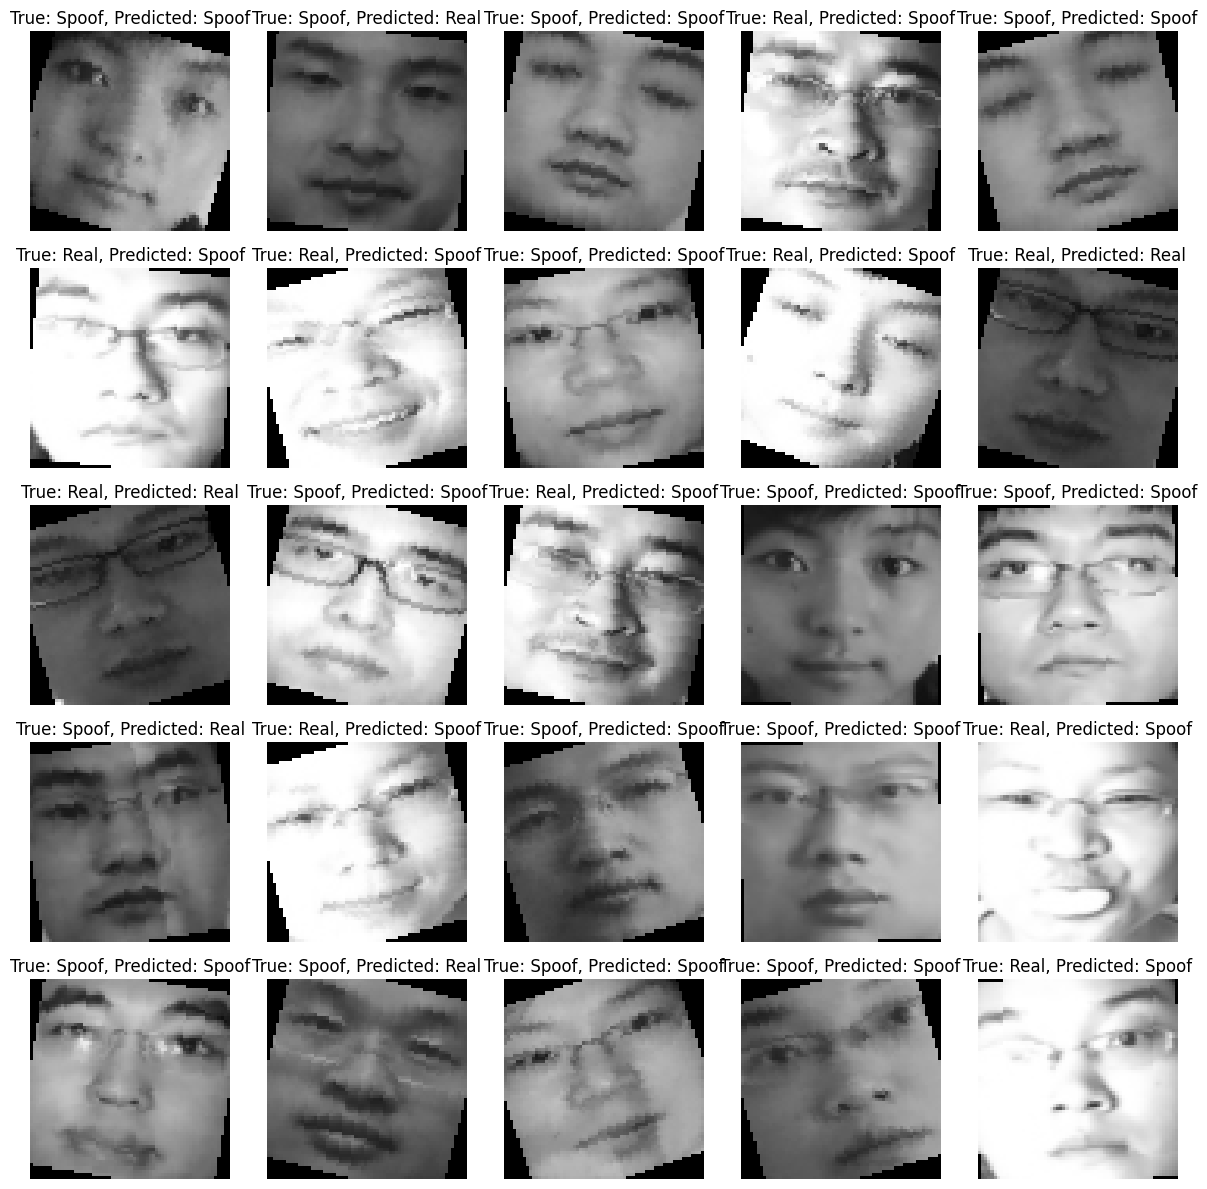

In [57]:
# Visualize Sample Predictions
# Use the trained model for inference on test data
model.eval()

plt.figure(figsize=(12, 12))
num_samples = 25
for i in range(num_samples):
    plt.subplot(5, 5, i + 1)
    idx = random.randint(0, len(test_dataset))
    sample_image, sample_label = test_dataset[idx]
    sample_image = sample_image.unsqueeze(0).to(device)

    with torch.no_grad():
        predicted_logits = model(sample_image)
        _, predicted_class = torch.max(predicted_logits, 1)

    sample_image = sample_image.squeeze(0).cpu().numpy().transpose((1, 2, 0))
    plt.imshow(sample_image)
    plt.title(f"True: {face_dic[sample_label.item()]}, Predicted: {face_dic[predicted_class.item()]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

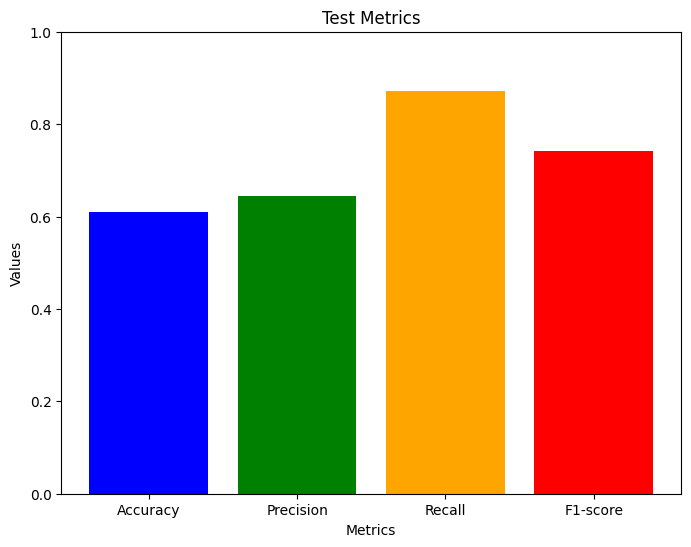

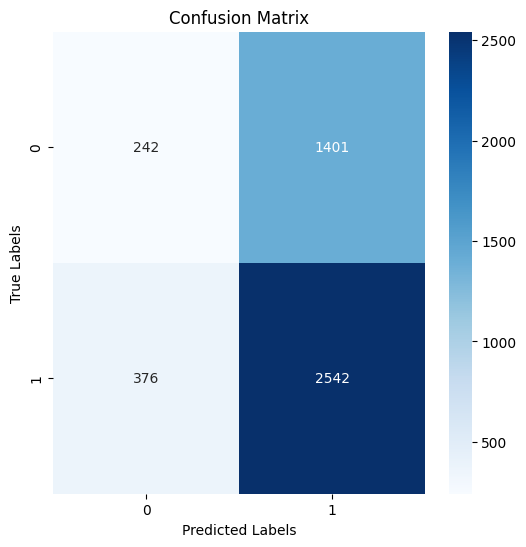

In [43]:
# Visualize Test Metrics
# Calculate the test metrics

# Visualize accuracy, precision, recall, and F1-score
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [test_accuracy, test_precision, test_recall, test_f1]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])
plt.ylim(0, 1)
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Test Metrics')
plt.show()

# Visualize the Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Conclusions

#### - The test accuracy of approximately 61.24% indicates that the model correctly classified about 61.24% of the test samples.

#### - With a test precision of around 64.59%, the model correctly identified about 64.59% of the samples predicted as spoofed faces out of all positive predictions.

#### - The test recall, at approximately 87.22%, indicates that the model correctly identified about 87.22% of the true spoofed faces in the test dataset.

#### - The F1-score of about 74.22% represents a good balance between precision and recall, providing an overall measure of the model's performance.

#### - The confusion matrix reveals detailed predictions. The model correctly identified 2545 true spoofed faces (TP) and 248 true real faces (TN). However, it misclassified 1395 real faces as spoofed faces (FP) and 373 spoofed faces as real faces (FN).
                                 1. True Positives (TP): 2545
                                 2. False Positives (FP): 1395
                                 3. True Negatives (TN): 248
                                 4. False Negatives (FN): 373

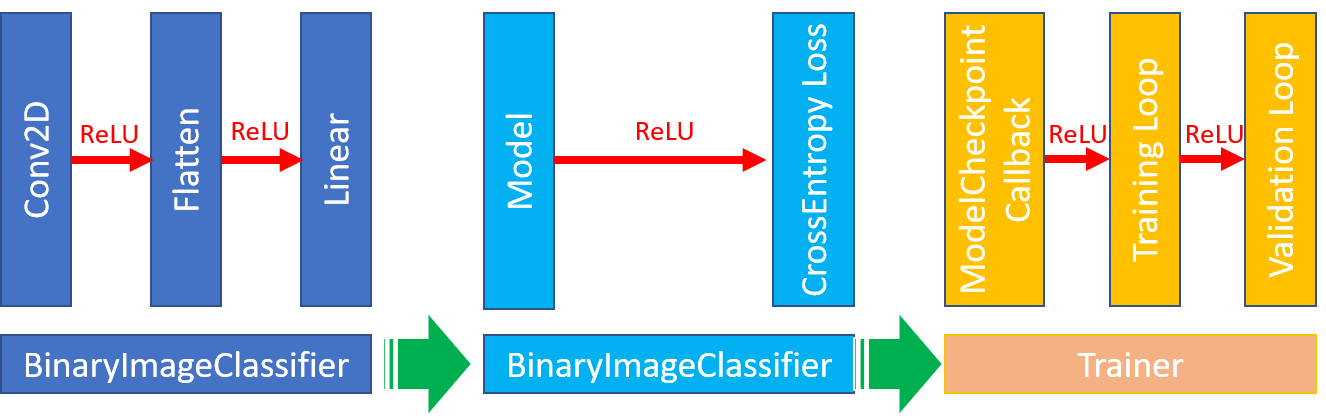